In [23]:
import os
import cv2
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import confusion_matrix, classification_report

### Loading Data 

In [2]:
def load_data(directory):
    images = []
    labels = []
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        # Check if class_path is a directory
        if not os.path.isdir(class_path):
            print(f"Skipping non-directory: {class_path}")
            continue
        
        images_path = os.path.join(class_path, 'images')
        labels_path = os.path.join(class_path, 'labels')

        # Check if both images and labels directories exist
        if not os.path.isdir(images_path) or not os.path.isdir(labels_path):
            print(f"Invalid directory structure in {class_path}. Skipping.")
            continue
        
        # Use class_name as the category label
        category_label = class_name 
        
        # Loop through each image in the images directory
        for image in os.listdir(images_path):
            if image.startswith('.'):  # Skip hidden files
                continue

            img_path = os.path.join(images_path, image)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image {image}, skipping.")
                continue
            
            # Resize the image to (224 x 224)
            img = cv2.resize(img, (224, 224))

            # Convert to RGB if it's grayscale
            if img.ndim == 2:  # If the image is grayscale (2D)
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to 3 channels (RGB)

            # Append image and label
            images.append(img)
            labels.append(category_label)  # Append the category label

    return np.array(images), np.array(labels)


# Data generator with explicit type conversion
import time

def my_generator(images, labels, batch_size):
    num_samples = len(images)
    while True:  # Loop indefinitely
        for offset in range(0, num_samples, batch_size):
            batch_images = images[offset:offset + batch_size]
            batch_labels = labels[offset:offset + batch_size]

            # Start timing
            start_time = time.time()

            # Preprocess images here (e.g., resizing, normalization)
            processed_images = preprocess_images(batch_images) 

            # End timing
            end_time = time.time()
            elapsed_time = end_time - start_time

            # Log the time taken for each batch
            print(f"Time taken to process batch {offset // batch_size}: {elapsed_time:.4f} seconds")

            yield processed_images, batch_labels






In [3]:
# Paths to data directories
train_path = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Train'
val_path = '/Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val'

# Load training and validation data
train_images, train_labels = load_data(train_path)
val_images, val_labels = load_data(val_path)

# Scale images to [0, 1]
train_images_np = train_images.astype(np.float32) / 255.0
val_images_np = val_images.astype(np.float32) / 255.0



Skipping non-directory: /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Train/.DS_Store
Skipping non-directory: /Users/NaomiLopez/Documents/Springboard/Projects/Capstone_Three/data/Val/.DS_Store


### Encoding Classes 

4 classes in total: Glioma, Meningioma, Pituitary, No Tumor

In [4]:
# One-hot encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

#Get number of unique classes 
num_classes = len(np.unique(train_labels_encoded))  


# One-hot encoding for multi-class classification (ensure float32 type)
train_labels_categorical = to_categorical(train_labels_encoded, num_classes=num_classes).astype(np.float32)
val_labels_categorical = to_categorical(val_labels_encoded, num_classes=num_classes).astype(np.float32)


### Data Augmentation: as seen in cleaning/EDA notebook

Train labels shape: (3670, 4), dtype: float32
Validation labels shape: (512, 4), dtype: float32


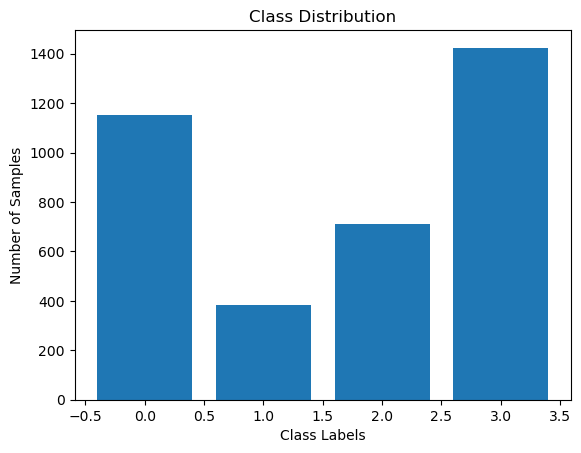

In [5]:
# Data augmentation
datagen = ImageDataGenerator(rescale=1.0/255.0)

# One-hot encode labels and ensure they are of type float32
train_labels_categorical = to_categorical(train_labels_encoded, num_classes=num_classes).astype(np.float32)
val_labels_categorical = to_categorical(val_labels_encoded, num_classes=num_classes).astype(np.float32)

print(f'Train labels shape: {train_labels_categorical.shape}, dtype: {train_labels_categorical.dtype}')
print(f'Validation labels shape: {val_labels_categorical.shape}, dtype: {val_labels_categorical.dtype}')

train_generator = datagen.flow(train_images_np, train_labels_categorical, batch_size=32)
val_generator = datagen.flow(val_images_np, val_labels_categorical, batch_size=32)

# Check class distribution in training data
unique, counts = np.unique(train_labels_encoded, return_counts=True)  # Use the encoded labels
class_distribution = dict(zip(unique, counts))

# Plot class distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

# Compute class weights to address imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels_encoded),
    y=train_labels_encoded
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


### Building CNN Model

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the model using MobileNet
base_model = MobileNet(weights='imagenet', include_top=False)

# Build the Sequential model
model = Sequential()
model.add(Input(shape=(224, 224, 3)))  # Input layer
model.add(base_model)  # Add the pre-trained MobileNet model
model.add(Flatten())   # Flatten the output of the base model
model.add(Dense(128, activation='relu'))  # Add a fully connected layer
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks for monitoring training
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model using train_generator and val_generator
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  
    callbacks=[checkpoint, early_stopping]
)


/var/folders/7j/32pl6tv92ng7gvr5j2ky1m_w0000gn/T/ipykernel_79939/2190843633.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)


Epoch 1/10


/Users/NaomiLopez/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 358s 3s/step - accuracy: 0.7868 - loss: 0.8391 - val_accuracy: 0.1953 - val_loss: 3.0346
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.9558 - loss: 0.1224 - val_accuracy: 0.1953 - val_loss: 4.5989
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.9746 - loss: 0.0775 - val_accuracy: 0.2090 - val_loss: 4.8875
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.9830 - loss: 0.0547 - val_accuracy: 0.4805 - val_loss: 3.0448


In [12]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,912,334 (110.29 MB)

 Trainable params: 9,630,148 (36.74 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 19,260,298 (73.47 MB)

### Evaluating Model Performance


In [14]:
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_images_np) // 32)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 503ms/step - accuracy: 0.1922 - loss: 3.0401
Validation Loss: 3.0346
Validation Accuracy: 0.1953


#### Interpretation of Model Performance

Low Accuracy: An accuracy of around 19.2% to 19.5% indicates that the model is not performing well on the validation set. 

High Loss: A loss value of around 3.04 also suggests that the model is struggling to learn the patterns in the validation data. This could be due to various factors, such as:

The model may be too complex for the amount of training data available, leading to overfitting.
The model might not be complex enough to capture the underlying patterns in the data (underfitting).
The training process (e.g., learning rate, batch size) might need adjustment.
Data preprocessing or augmentation might need improvement.

#### Improvement: 

- More Training: Train the model for more epochs to see if accuracy improves. Monitor training and validation accuracy/loss to avoid overfitting.

- Data Augmentation: Implement data augmentation techniques to increase the diversity of the training set and prevent overfitting.

- Hyperparameter Tuning: Experiment with different learning rates, batch sizes, and model architectures to find the optimal configuration.

- Model Complexity: Adjust the complexity of the model. I could add or remove layers, change the number of filters, or adjust the activation functions.

- Regularization Techniques: Implement dropout or other regularization techniques to prevent overfitting.

- Learning Rate Scheduling: Consider using learning rate schedules or callbacks to adjust the learning rate dynamically during training.

- Transfer Learning: I attempted to use transfer leanrning with VGG16 but the amount of storage and power of my compputer was too low to handle this method. 

- Check Data Quality: Ensure that the labels are correct and that there’s no data leakage between training and validation sets.

In [21]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Print predicted classes
print("Predicted classes:", predicted_classes)


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 511ms/step
Predicted classes: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

#### Interpretation of Model Prediction on validation (test data)

Predicted Classes: The array [2, 2, 2, 2, ...] suggests that every image in the test set is classified as class 2. 

This could imply:

- Model Limitations: The model may not have learned the distinguishing features of the other classes, resulting in it defaulting to predicting the most frequent class.

- Underfitting: The model might be too simple to capture the complexity of the data. I thought this could happen since the dataset includes images from different planes (sagittal, transverse, coronal).

- There could have been an issue when attempting to balance the classes. 

### Visualizing Results

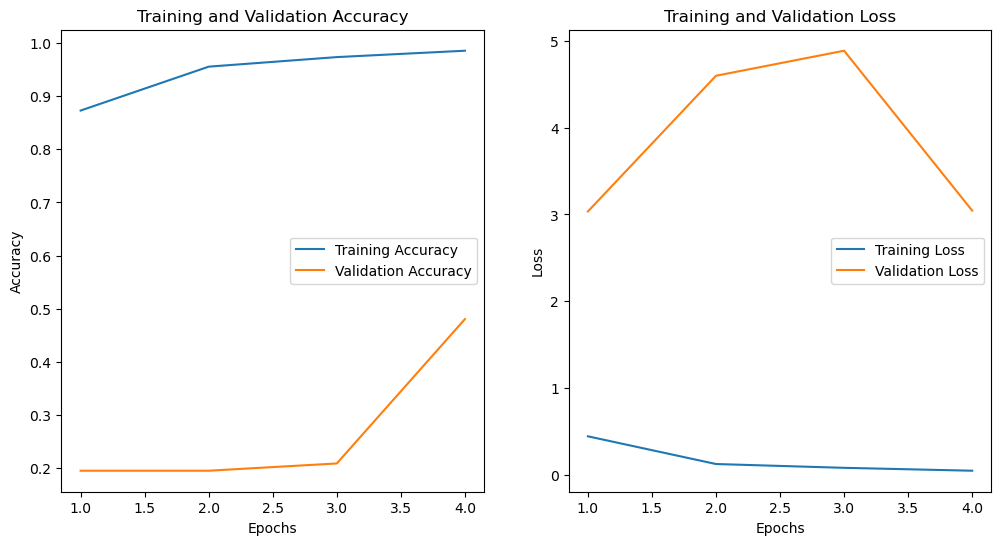

In [19]:

# Plot training & validation accuracy and loss values
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Conclusion

In this project, I built and CNN model using pre-trained MobileNet to classify MRI brain tumor images. The model was trained with transfer learning and regularization techniques to improve performance, but despite achieving 98.3% accuracy on the training data, the validation performance was significantly lower, with a validation accuracy fluctuating between 19.5% and 48.1% across the epochs.

This wide gap between training and validation accuracy strongly indicates overfitting. While the model was able to memorize the training data, it struggled to generalize to unseen validation data. The following factors may have contributed to this result:

- Data Complexity: 

The dataset included images from different planes (sagittal, transverse, coronal), which may have added complexity, making it harder for the model to generalize.

- Class Imbalance: The distribution of classes in the training data was imbalanced, possibly skewing the model toward predicting the majority class. Although I attempted to weight the classes, it seems this method was not enough.


- Limited Validation Accuracy:

The validation accuracy plateaued at 48.1%, indicating the model failed to capture meaningful patterns for the other classes, as shown by misclassifications and a bias towards predicting class 2 in most cases.

- Areas for Improvement

To enhance the model's performance, I would:


Data Augmentation: I could incorporate more diverse data augmentation techniques to better represent variations within the training data and help prevent overfitting.
Hyperparameter Tuning: Experimenting with learning rates, batch sizes, and dropout rates could improve generalization.
Regularization and Model Architecture: Exploring a VGG16 pre trained model might reduce overfitting.
